## First Step: Data Loading

We need to load SNWD data from the weather dataset. 
* The parquet file is ../../../weather_data/weather_1950_2025_combined.parquet
* We want to load years 1950-2025 of SNWD for all available stations
* The data should be in wide format with daily snow depth values for each station-year combination.


In [1]:
import dask.dataframe as dd
# Load SNWD data for all available years (1950-2025)
weather_data_all_years = dd.read_parquet('../../../weather_data/weather_1950_2025_combined.parquet')
snwd_data = weather_data_all_years[weather_data_all_years['ELEMENT'] == 'SNWD']

print(f"Loaded {len(snwd_data)} SNWD records for all years")
#print(f"Years: {sorted(snwd_data['year'].unique())}")
#print(f"Stations: {snwd_data['ID'].nunique()}")


Loaded 1015287 SNWD records for all years


In [2]:
import dask.dataframe as dd
# Load all available years of SNWD data
snwd_data = dd.read_parquet('../../../weather_data/weather_1950_2025_combined.parquet').query(
    "ELEMENT == 'SNWD'"
).compute()
print("snwd_data shape:", snwd_data.shape)

print(f"Loaded {len(snwd_data)} SNWD records (all years)")
#print(f"Years: {sorted(snwd_data['year'].unique())}")
#print(f"Stations: {snwd_data['ID'].nunique()}")


snwd_data shape: (1015287, 368)
Loaded 1015287 SNWD records (all years)


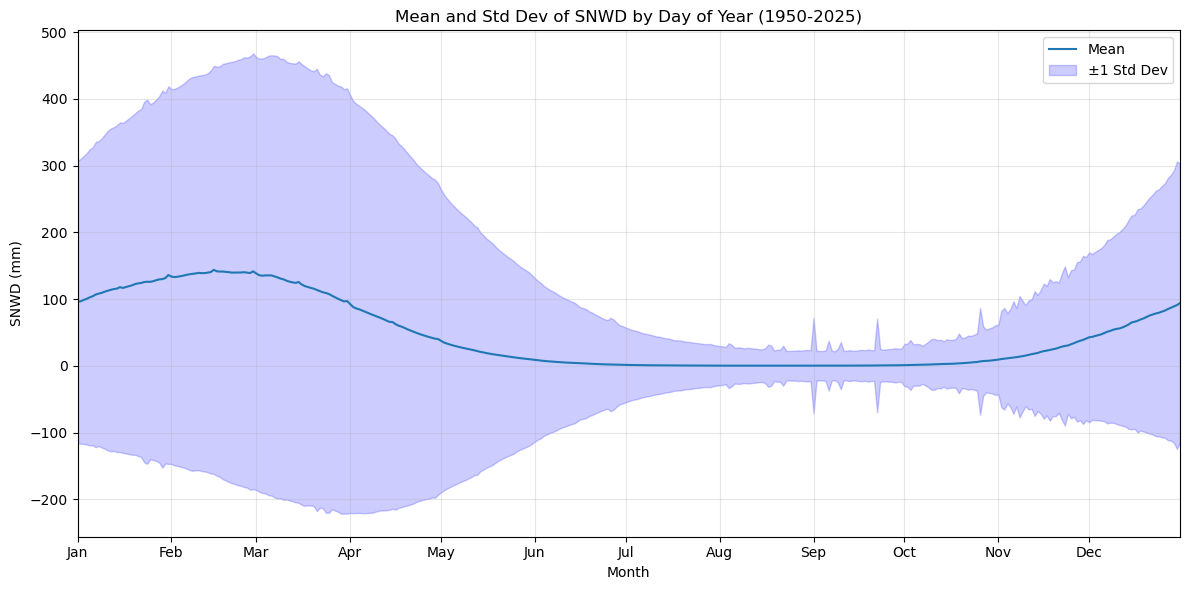

In [3]:
from dask_pca import plot_mean_std
# Use the function on the SNWD data
daily_means, daily_stds = plot_mean_std(snwd_data, title="Mean and Std Dev of SNWD by Day of Year (1950-2025)", ylabel="SNWD (mm)")


In [ ]:
import dask.dataframe as dd

stations_df = dd.read_parquet("../weather_info/stations_dask.parquet")

print("stations_df columns:", stations_df.columns)


stations_df columns: Index(['station_id', 'latitude', 'longitude', 'elevation', 'state', 'name',
       'gsn_flag', 'hcn_crn_flag', 'wmo_id'],
      dtype='object')


: 

In [ ]:

# Fixed cell to prevent kernel crashes
# Check if weather_data_all_years exists and its size
try:
    print(f"weather_data_all_years shape: {weather_data_all_years.shape}")
    print(f"weather_data_all_years type: {type(weather_data_all_years)}")
except NameError:
    print("weather_data_all_years not defined. Loading weather data...")
    # Load weather data safely
    weather_data_all_years = dd.read_parquet("../../../weather_data/stations_weather_with_dist2coast.parquet")
    print(f"Loaded weather data shape: {weather_data_all_years.shape}")

# Cast station_id into string before merging (only if needed)
if 'station_id' in stations_df.columns:
    stations_df['station_id'] = stations_df['station_id'].astype('string')

# Perform merge with memory optimization
print("Performing merge...")
joined_df = stations_df.merge(
    weather_data_all_years, 
    left_on='station_id', 
    right_on='ID', 
    how='inner'
)

# Optimize partitioning for memory efficiency
print("Optimizing partitions...")
# Calculate optimal partitions based on data size
n_rows = len(joined_df)
if n_rows < 1000000:  # < 1M rows
    optimal_partitions = 4
elif n_rows < 10000000:  # < 10M rows
    optimal_partitions = 8
elif n_rows < 100000000:  # < 100M rows
    optimal_partitions = 16
else:  # >= 100M rows
    optimal_partitions = 32

joined_df = joined_df.repartition(npartitions=optimal_partitions)
print(f"Repartitioned to {optimal_partitions} partitions")

# Persist to avoid recomputation
print("Persisting result...")
joined_df = joined_df.persist()

print(f"Join complete! Result shape: {joined_df.shape}")
print("Ready for further analysis...")

# Uncomment the line below to save (only if you want to save the result)
# joined_df.to_parquet("../../../weather_data/joined_stations_weather.parquet", engine="pyarrow")


In [ ]:
import matplotlib.pyplot as plt

# Compute hemisphere for each station based on latitude
joined_df['hemisphere'] = joined_df['latitude'].map(lambda lat: 'Northern' if lat >= 0 else 'northern', meta=('latitude', 'object'))

# Use plot_mean_std for hemisphere subsets, store outputs
northern_df = joined_df[joined_df['hemisphere'] == 'Northern']
northern_df = joined_df[joined_df['hemisphere'] == 'northern']

northern_mean, northern_std = plot_mean_std(
    northern_df,
    title="Mean and Std Dev of SNWD by Day of Year (Northern Hemisphere, 1950-2025)",
    ylabel="SNWD (mm)"
)
northern_mean, northern_std = plot_mean_std(
    northern_df,
    title="Mean and Std Dev of SNWD by Day of Year (northern Hemisphere, 1950-2025)",
    ylabel="SNWD (mm)"
)


In [ ]:
# Use the general-purpose plot_mean_and_pcs function for northern hemisphere data
from dask_pca import plot_mean_and_pcs
import numpy as np

# Prepare the data: convert northern_df to array format
northern_df_computed = northern_df.compute()
day_cols = [f'day_{i}' for i in range(1, 366)]
northern_data = northern_df_computed[day_cols].values

# Create x-axis values (days of year)
days = np.arange(1, 366)

# Use the general-purpose function
mean, components, explained_variances = plot_mean_and_pcs(
    data=northern_data,
    n_components=3,
    title='Mean SNWD and Top 3 Principal Components (northern Hemisphere, 1950-2025)',
    xlabel='Day of Year',
    ylabel='Mean SNWD (mm)',
    signal_name='SNWD',
    x_values=days,
    figsize=(12, 6)
)


In [ ]:
# Compute and plot the cumulative percentage of variance explained by the top K eigenvectors for SNWD in the northern hemisphere

# Calculate explained variance ratio (percentage)
explained_variance_ratio = (explained_variances_ / explained_variances_.sum()).flatten() * 100

# Compute cumulative sum as cumulative percentage explained
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plot cumulative percentage of variance explained as a function of K
plt.figure(figsize=(10,6))
plt.plot(range(1, len(cumulative_explained_variance)+1), cumulative_explained_variance, marker='o')
plt.xlabel('Number of Principal Components (K)')
plt.ylabel('Cumulative Percentage of Variance Explained (%)')
plt.title('Cumulative Percentage of Variance Explained by Top K Principal Components\nSNWD (northern Hemisphere, 1950-2025)')
plt.xticks(range(1, len(cumulative_explained_variance)+1))
plt.yticks(np.arange(0, 101, 10))
plt.grid(axis='y', alpha=0.3)
plt.show()


In [ ]:
import pickle

# Save the mean and eigenvectors (principal components) to snwd.pkl
with open("snwd.pkl", "wb") as f:
    pickle.dump({"mean": mean, "components": components}, f)
